## 1. Environment Setup and Imports
Ensure we're using the correct kernel and loading utils from the `src/` directory.

In [1]:
import sys, os
sys.path.append(os.path.abspath("../src"))

# Torch & GNN
import torch
from torch_geometric.nn import GCNConv

from load_elliptic_data import load_and_preprocess_elliptic_data
from data_utils_randomsplit import random_split
from model_gcn import GCNNet
from train_utils import set_seed, train_full, save_config
from config import SEEDS

print("All modules imported successfully.")


All modules imported successfully.


## 2: Load and Preprocess Data


In [2]:
# Load preprocessed Elliptic data
data = load_and_preprocess_elliptic_data("../elliptic_bitcoin_dataset")
print(data)


Data(x=[203769, 166], edge_index=[2, 234355], y=[203769])


## 3. Initialize the GCN Model
Set hyperparameters and move model/data to GPU/CPU if available.

In [4]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
hidden_channels = 8
dropout = 0.3
out_channels = 2
in_channels = data.x.shape[1]

# Model initialization
model = GCNNet(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    dropout=dropout
).to(device)

data = data.to(device)
print(model)


GCNNet(
  (conv1): GCNConv(166, 8)
  (conv2): GCNConv(8, 2)
)


## 4: Initialize the GCN Model

This step creates the GCN architecture and moves it to the appropriate device. The model is defined in `src/model_gcn.py` with two layers and ReLU + dropout in between.


In [4]:
from train_multiseed import train_and_evaluate_multiseed
from config import SEEDS

for seed in SEEDS:
    print(f"Running seed {seed}...")
    train_and_evaluate_multiseed(seed, data, model_type="GCN")


Running seed 42...
Epoch 001 | Loss: 1.9450 | Val Acc: 0.3770 | Val F1: 0.3355
Epoch 002 | Loss: 1.8083 | Val Acc: 0.4383 | Val F1: 0.3775
Epoch 003 | Loss: 1.6939 | Val Acc: 0.5014 | Val F1: 0.4189
Epoch 004 | Loss: 1.3330 | Val Acc: 0.5637 | Val F1: 0.4579
Epoch 005 | Loss: 1.2477 | Val Acc: 0.6367 | Val F1: 0.5038
Epoch 006 | Loss: 0.8963 | Val Acc: 0.7019 | Val F1: 0.5445
Epoch 007 | Loss: 0.8427 | Val Acc: 0.7554 | Val F1: 0.5782
Epoch 008 | Loss: 0.6437 | Val Acc: 0.8022 | Val F1: 0.6130
Epoch 009 | Loss: 0.5661 | Val Acc: 0.8310 | Val F1: 0.6363
Epoch 010 | Loss: 0.4624 | Val Acc: 0.8493 | Val F1: 0.6491
Epoch 011 | Loss: 0.4136 | Val Acc: 0.8612 | Val F1: 0.6547
Epoch 012 | Loss: 0.3808 | Val Acc: 0.8714 | Val F1: 0.6575
Epoch 013 | Loss: 0.3541 | Val Acc: 0.8817 | Val F1: 0.6606
Epoch 014 | Loss: 0.3610 | Val Acc: 0.8881 | Val F1: 0.6595
Epoch 015 | Loss: 0.3060 | Val Acc: 0.8939 | Val F1: 0.6594
Epoch 016 | Loss: 0.2969 | Val Acc: 0.8976 | Val F1: 0.6549
Epoch 017 | Loss: 0.2

## 5. Evaluation and Visualization
### 5.1 Imports and set up

In [2]:
import sys
sys.path.append("../src")

from evaluation_pipeline import (
    run_inference_all_seeds,
    plot_conf_matrices,
    summarize_classification_report,
    save_fp_fn_indices,
    attach_node_times,
    plot_fp_fn_time_distributions  # already includes raw + normalized plots
)

from analysis_utils import (
    load_metrics_across_seeds,
    aggregate_metrics_table,
    plot_loss_curve
)

from model_gcn import GCNNet
from load_elliptic_data import load_and_preprocess_elliptic_data

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seeds = [42, 123, 777, 2023, 31415]

# Load data and model class
data = load_and_preprocess_elliptic_data("../elliptic_bitcoin_dataset").to(device)
model_class = GCNNet
model_dir = "../models_v2/GCN"


### 5.2 Load Log Metrics and Loss Curve

,Metric,Mean,Std,Formatted
0,val_acc,0.9510,0.0017,0.9510 ± 0.0017
1,val_f1_macro,0.8407,0.0058,0.8407 ± 0.0058
2,val_f1_illicit,0.9732,0.0009,0.9732 ± 0.0009


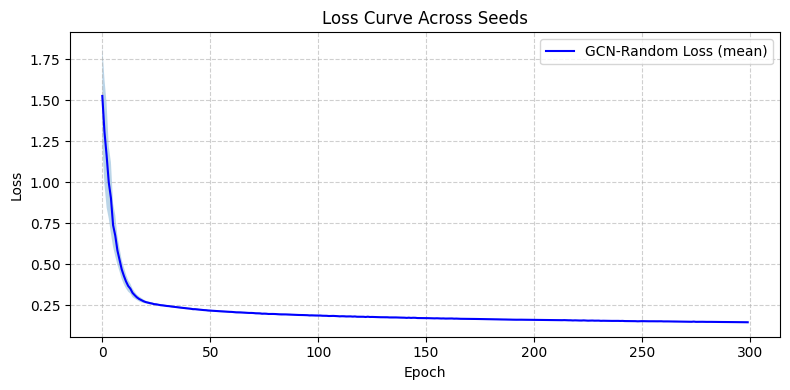

In [3]:
metrics_logs = load_metrics_across_seeds(model_dir, ["val_acc", "val_f1_macro", "val_f1_illicit", "loss"])
summary_df = aggregate_metrics_table(metrics_logs)
display(summary_df)
plot_loss_curve(metrics_logs["loss"], label="GCN-Random Loss")

### 5.3 Inference Across Seeds

In [4]:
y_true_all, y_pred_all, y_proba_all, seed_metrics = run_inference_all_seeds(
    model_dir=model_dir,
    model_class=model_class,
    data=data,
    seeds=seeds
)

### 5.4 Confusion Matrices (Normalised as well)

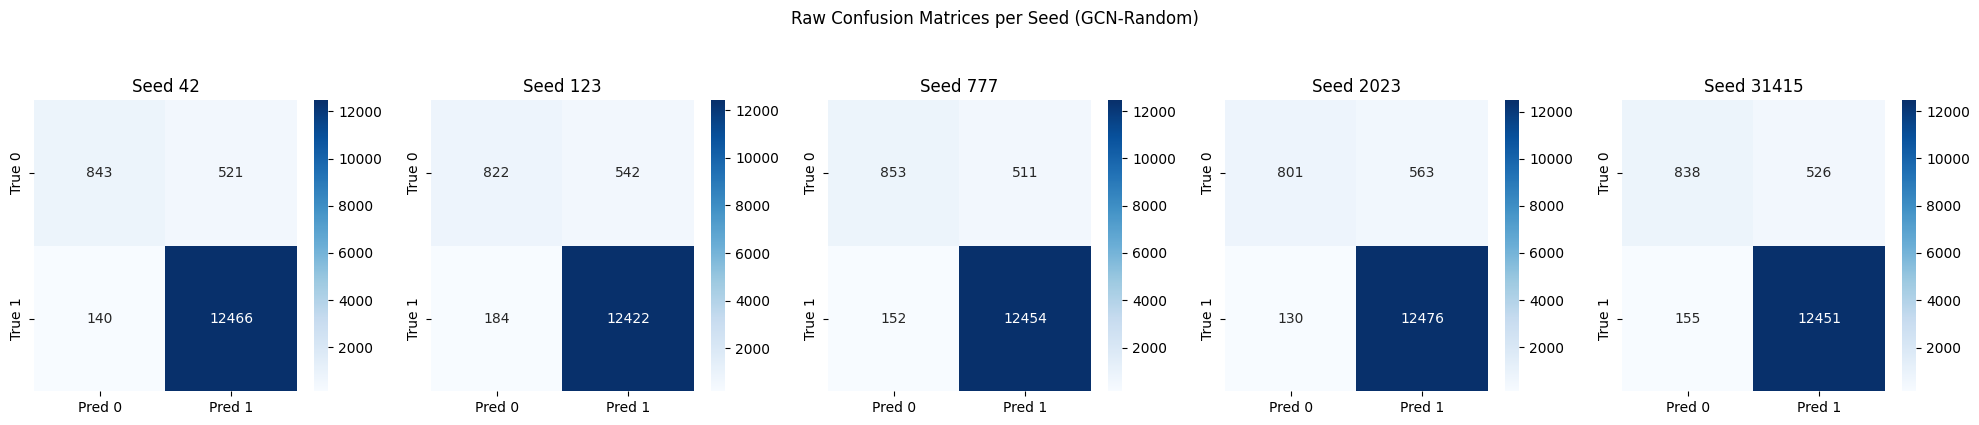

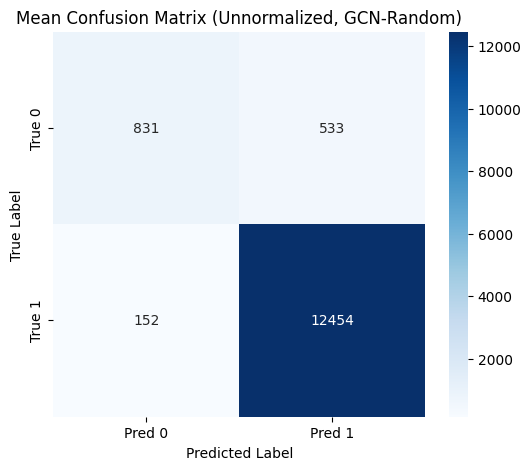

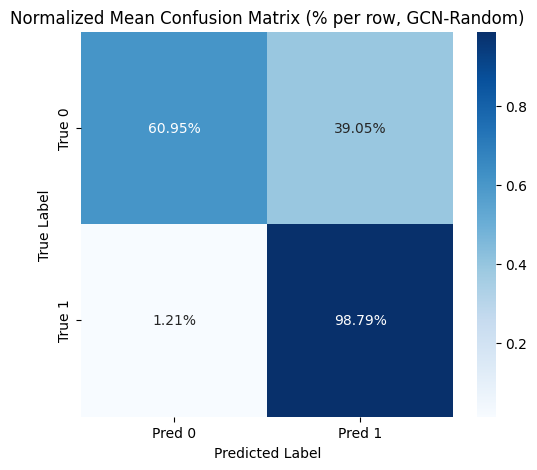

In [5]:
plot_conf_matrices(y_true_all, y_pred_all, seeds, model_name="GCN-Random")

### 5.5 GCN Metric Summary Across Seeds

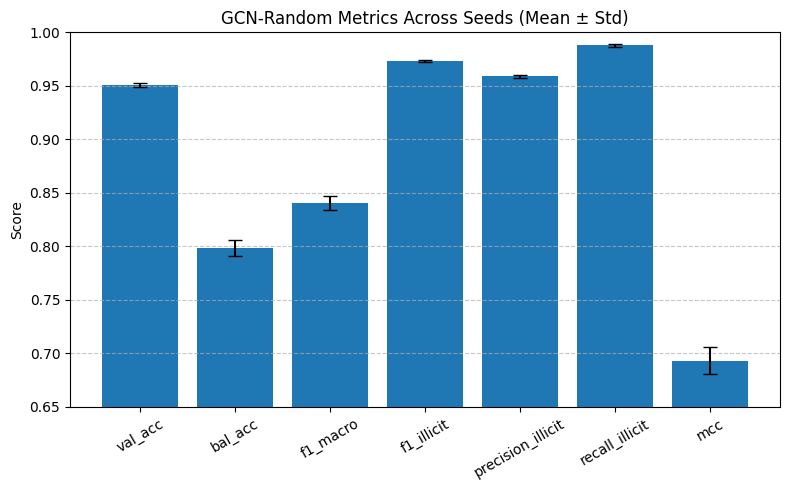

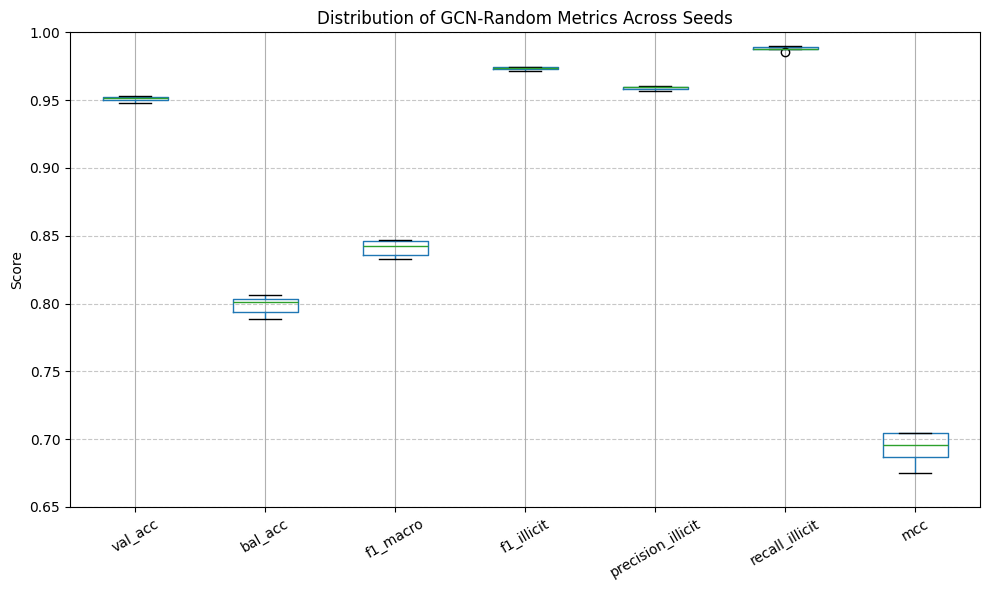

,Metric,Mean,Std,Formatted
0,val_acc,0.9510,0.0019,0.9510 ± 0.0019
1,bal_acc,0.7987,0.0074,0.7987 ± 0.0074
2,f1_macro,0.8407,0.0064,0.8407 ± 0.0064
3,f1_illicit,0.9732,0.0010,0.9732 ± 0.0010
4,precision_illicit,0.9590,0.0015,0.9590 ± 0.0015
5,recall_illicit,0.9879,0.0016,0.9879 ± 0.0016
6,mcc,0.6932,0.0125,0.6932 ± 0.0125


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Inject val_acc from metrics_logs into seed_metrics
val_acc_list = metrics_logs["val_acc"]  # From load_metrics_across_seeds earlier

# Add val_acc to each seed's metric dictionary
for i in range(len(seed_metrics)):
    seed_metrics[i]["val_acc"] = val_acc_list[i]

# Construct DataFrame from all metrics
df = pd.DataFrame(seed_metrics)

# Define core metrics to evaluate
main_metrics = ['val_acc', 'bal_acc', 'f1_macro', 'f1_illicit', 'precision_illicit', 'recall_illicit', 'mcc']

# Compute mean and std across seeds
means = df[main_metrics].mean()
stds = df[main_metrics].std()

# === Bar Plot (Mean ± Std) ===
plt.figure(figsize=(8, 5))
plt.bar(main_metrics, means, yerr=stds, capsize=5)
plt.ylim(0.65, 1.0)
plt.title("GCN-Random Metrics Across Seeds (Mean ± Std)")
plt.xticks(rotation=30)
plt.ylabel("Score")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# === Boxplot (Seed-wise distribution) ===
plt.figure(figsize=(10, 6))
df[main_metrics].boxplot()
plt.ylim(0.65, 1.0)
plt.title("Distribution of GCN-Random Metrics Across Seeds")
plt.xticks(rotation=30)
plt.ylabel("Score")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# === Summary Table (Mean ± Std, formatted for paper/report) ===
summary_table = pd.DataFrame({
    "Metric": main_metrics,
    "Mean": means.round(4).values,
    "Std": stds.round(4).values,
    "Formatted": [f"{m:.4f} ± {s:.4f}" for m, s in zip(means, stds)]
})

# Ensure order matches plot and report order
summary_table = summary_table.set_index("Metric").loc[main_metrics].reset_index()

display(summary_table)


### 5.6 Class-Wise Precision Recall F1 etc

In [7]:
summarize_classification_report(y_true_all, y_pred_all)



Legit (0) Metrics:
precision: 0.8455 ± 0.0154
recall: 0.6095 ± 0.0133
f1-score: 0.7083 ± 0.0107

Illicit (1) Metrics:
precision: 0.9590 ± 0.0013
recall: 0.9879 ± 0.0014
f1-score: 0.9732 ± 0.0009


### 5.7 FP/FN Indices

In [8]:
save_fp_fn_indices(y_true_all, y_pred_all, seeds, model_dir)


### 5.8 Attach Timestamps and FP/FN Time Analysis (Raw and Normalised)

In [9]:
data = attach_node_times(data, "../elliptic_bitcoin_dataset/elliptic_txs_features.csv")

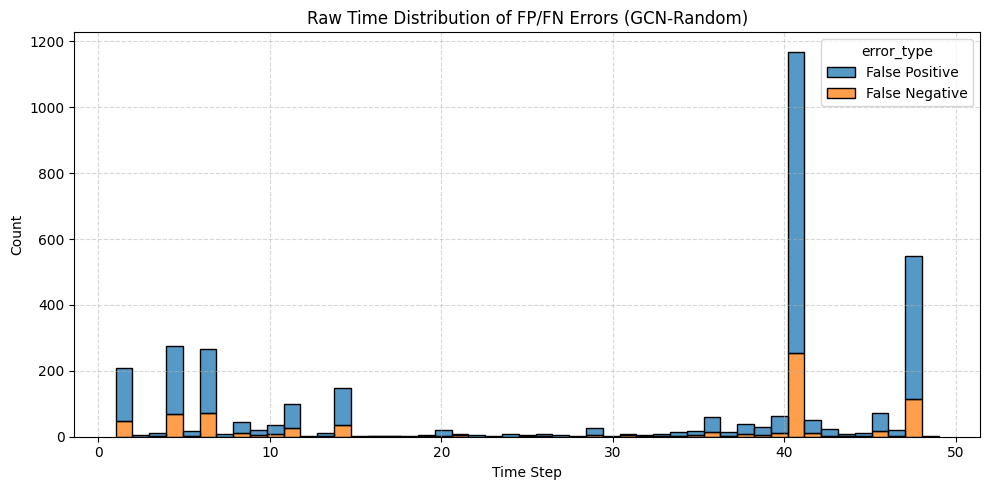

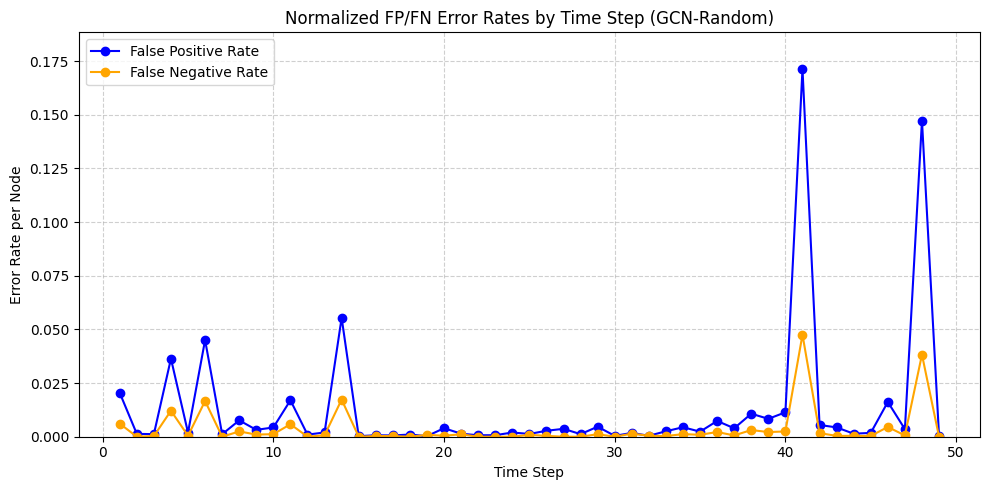

In [10]:
plot_fp_fn_time_distributions(data, seeds, model_dir, model_name="GCN-Random")

### 6. Export to JSON

In [11]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from evaluation_pipeline import export_full_evaluation_to_json

# --------------------------------------------
# Reconstruct confusion matrices (per seed)
# --------------------------------------------
conf_matrices = [
    confusion_matrix(y_true_all[i], y_pred_all[i])
    for i in range(len(seeds))
]

# --------------------------------------------
# Reconstruct FP/FN counts + time distributions
# using saved indices and timestamps
# --------------------------------------------
model_dir = "../models_v2/GCN"  # <-- change per model
fp_counts, fn_counts = [], []
fp_time_all, fn_time_all = [], []

timestamps = data.node_times.cpu().numpy()

for seed in seeds:
    base = os.path.join(model_dir, f"seed_{seed}")
    fp_idx = np.load(os.path.join(base, "fp_indices.npy"))
    fn_idx = np.load(os.path.join(base, "fn_indices.npy"))

    fp_counts.append(len(fp_idx))
    fn_counts.append(len(fn_idx))

    fp_time_all.extend(timestamps[fp_idx])
    fn_time_all.extend(timestamps[fn_idx])

# Convert to JSON-compatible native Python types
fp_time_all = [int(t) for t in fp_time_all]
fn_time_all = [int(t) for t in fn_time_all]

# --------------------------------------------
# Final export to JSON files
# --------------------------------------------
export_full_evaluation_to_json(
    seed_metrics=seed_metrics,
    conf_matrices=conf_matrices,
    fp_counts=fp_counts,
    fn_counts=fn_counts,
    fp_time_all=fp_time_all,
    fn_time_all=fn_time_all,
    output_dir=model_dir
)
